# Classification models

We can now create a classification model.

As always, we will start by importing the necessary libraries and loading the data.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import joblib
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    PowerTransformer,
)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.dummy import DummyClassifier

# linear models
from sklearn.linear_model import LogisticRegression

# tree models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# svm
from sklearn.svm import SVC

# kNN
from sklearn.neighbors import KNeighborsClassifier

from churn.config import BEST_MODEL_FILE, PROCESSED_DATA_FILE
from churn.plots import (
    plot_model_performance_metrics,
    plot_coefficients,
    plot_ks_curve,
)
from churn.models import RANDOM_STATE
from churn.models import (
    build_coefficients_dataframe,
    get_mean_and_std_from_grid_search_best_estimator,
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    summarize_model_performance,
)

In [2]:
df = pd.read_parquet(PROCESSED_DATA_FILE, engine="fastparquet")

df.head()

,Contract,Dependents,DeviceProtection,InternetService,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PaymentMethod,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,MonthlyCharges,Tenure,Churn
0,Month-to-month,No,No,DSL,Yes,No,Yes,Yes,Electronic check,No,No,No,No,29.85,1,No
1,One year,No,Yes,DSL,No,Yes,No,No,Mailed check,No,No,No,No,56.95,34,No
2,Month-to-month,No,No,DSL,Yes,Yes,Yes,No,Mailed check,No,No,No,No,53.85,2,Yes
3,One year,No,Yes,DSL,No,Yes,No,No,Bank transfer,No,No,No,Yes,42.30,45,No
4,Month-to-month,No,No,Fiber optic,No,No,Yes,No,Electronic check,No,No,No,No,70.70,2,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Contract          7043 non-null   category
 1   Dependents        7043 non-null   category
 2   DeviceProtection  7043 non-null   category
 3   InternetService   7043 non-null   category
 4   OnlineBackup      7043 non-null   category
 5   OnlineSecurity    7043 non-null   category
 6   PaperlessBilling  7043 non-null   category
 7   Partner           7043 non-null   category
 8   PaymentMethod     7043 non-null   category
 9   SeniorCitizen     7043 non-null   category
 10  StreamingMovies   7043 non-null   category
 11  StreamingTV       7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  MonthlyCharges    7043 non-null   float64 
 14  Tenure            7043 non-null   int8    
 15  Churn             7043 non-null   category
dtypes: category(14), float64

## Preprocessing setup



Prior to building the model, we need to preprocess the data. We will start by defining the target variable and the features:


In [4]:
target = "Churn"

X = df.drop(columns=target)
y = df[target]

le = LabelEncoder()
y = le.fit_transform(y.values.ravel())

X.shape, y.shape

((7043, 15), (7043,))

In [5]:
le.classes_

array(['No', 'Yes'], dtype=object)

In [6]:
df[target].values[:5], y[:5]

(['No', 'No', 'Yes', 'No', 'Yes']
 Categories (2, object): ['No', 'Yes'],
 array([0, 0, 1, 0, 1]))

We have seen in the previous notebooks that we have numerical and categorical features.
We will need to preprocess them separately. Among the categorical features, we will
treat them using one-hot encoding.

On the other hand, concerning the numerical features, we have noticed that they are
skewed. We will apply a power transformation to these to make them more
Gaussian-like.


In [7]:
columns_power_transformer = X.select_dtypes(include="number").columns.to_list()

columns_one_hot_encoder = X.select_dtypes(include="category").columns.to_list()

In [8]:
columns_power_transformer

['MonthlyCharges', 'Tenure']

In [9]:
columns_one_hot_encoder

['Contract',
 'Dependents',
 'DeviceProtection',
 'InternetService',
 'OnlineBackup',
 'OnlineSecurity',
 'PaperlessBilling',
 'Partner',
 'PaymentMethod',
 'SeniorCitizen',
 'StreamingMovies',
 'StreamingTV',
 'TechSupport']

Since the exploration of the data has shown that the target column is imbalanced, we
will use the stratified split to keep the same distribution of classes in the train and
test sets. This will be achieved by using the `StratifiedKFold` class from the `sklearn`
library.

The `StratifiedKFold` class will split the data into `n_splits` folds, keeping the same
distribution of classes in each fold. This allows us to train the model on different
subsets of the data and evaluate its performance on the test set.


In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

The SciKit-Learn library provides a `ColumnTransformer` class that allows us to apply
different transformations to different columns of the data. We will use this class to
apply the transformations to the data.

We will first test a handful of models to see which one performs best. Then, we will
fine-tune the hyperparameters of the best model to improve its performance.

Some models are tree-based models, which do not require scaling of the numerical
features. While the other models require scaling. So we are going to define two
variables, one for the tree-based models and one for the other models.


In [11]:
preprocessing_tree = ColumnTransformer(
    transformers=[
        (
            "one_hot_encoding",
            OneHotEncoder(drop="if_binary"),
            columns_one_hot_encoder,
        ),
    ],
    remainder="passthrough",
)

preprocessing_not_tree = ColumnTransformer(
    transformers=[
        (
            "one_hot_encoding",
            OneHotEncoder(drop="if_binary"),
            columns_one_hot_encoder,
        ),
        (
            "power_transformer",
            PowerTransformer(),
            columns_power_transformer,
        ),
    ]
)

As remembered before, we have an imbalanced target column. Most classification models
have a parameter called `class_weight` that allows us to give more importance to the
minority class. We will use this parameter, when available, to make the models give more
importance to the conversion class.

One of our models, the `LGMBClassifier`, has a parameter called `scale_pos_weight` that
allows us to give more importance to the minority class. We will use this parameter to
make the model give more importance to the conversion class. The value of this parameter
is calculated as the ratio of the number of samples in the majority class to the number
of samples in the minority class:


In [12]:
class_weight_proportion = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weight_ratio = class_weight_proportion[1] / class_weight_proportion[0]
class_weight_ratio

np.float64(2.7683253076511503)

## Evaluating some classification models

Let's define our classifiers. For comparison, a baseline model, `DummyClassifier`, will be
defined as well. The baseline model will make predictions based on the stratified
strategy, which predicts the most frequent class in the training set:

In [13]:
classifiers = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_not_tree,
        "classifier": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": preprocessing_tree,
        "classifier": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_tree,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=class_weight_ratio,
        ),
    },
    "SVC": {
        "preprocessor": preprocessing_not_tree,
        "classifier": SVC(class_weight="balanced", cache_size=2048, probability=True),
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessing_not_tree,
        "classifier": KNeighborsClassifier(),
    },
}

Some useful functions were defined to help us evaluate the models and summarize the results:

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    results = {
        model_name: train_and_validate_classification_model(X, y, kf, **classifier)
        for model_name, classifier in classifiers.items()
    }

df_results = summarize_model_performance(results)

df_results

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_neg_brier_score,test_f1_weighted,time_seconds
0,DummyClassifier,0.001871,0.01031,0.613201,0.499357,0.260516,0.264463,0.256684,0.507153,0.268336,-0.38538,0.611337,0.012181
1,DummyClassifier,0.001887,0.010817,0.597587,0.49129,0.258824,0.253197,0.264706,0.495942,0.263891,-0.386799,0.600392,0.012704
2,DummyClassifier,0.001721,0.010012,0.620298,0.50248,0.260028,0.269341,0.251337,0.514658,0.271623,-0.376863,0.615999,0.011733
3,DummyClassifier,0.001796,0.01025,0.586648,0.468482,0.217742,0.218329,0.217158,0.49057,0.261423,-0.40483,0.586292,0.012046
4,DummyClassifier,0.001526,0.009566,0.625,0.509159,0.270718,0.28,0.262032,0.527677,0.27802,-0.372869,0.620936,0.011092
5,LogisticRegression,0.087454,0.070899,0.756565,0.773679,0.638567,0.526957,0.81016,0.859192,0.664379,-0.157447,0.769255,0.158353
6,LogisticRegression,0.08078,0.065322,0.7445,0.76632,0.628099,0.511785,0.812834,0.844513,0.656223,-0.169025,0.758342,0.146101
7,LogisticRegression,0.091436,0.062483,0.760823,0.77487,0.641108,0.532743,0.804813,0.862117,0.68906,-0.155208,0.772992,0.15392
8,LogisticRegression,0.086557,0.062735,0.747159,0.754284,0.617204,0.51526,0.769437,0.828361,0.623873,-0.170203,0.759838,0.149292
9,LogisticRegression,0.096689,0.068872,0.747159,0.757879,0.621277,0.515901,0.780749,0.838919,0.656291,-0.167223,0.760043,0.165561


As we can see, each model has 5 entries, corresponding to the 5 folds of the
cross-validation. We have the following metrics:

- `accuracy`: the proportion of correctly classified samples;
- `balanced_accuracy`: the average of the recall of each class;
- `f1`: the harmonic mean of precision and recall;
- `precision`: the proportion of correctly classified positive samples;
- `recall`: the proportion of positive samples that were correctly classified;
- `roc_auc`: the area under the ROC curve.
- `average_precision`: the area under the precision-recall curve.
- `neg_brier_score`: the Brier score, which is the mean squared difference between the
predicted probabilities and the actual outcomes. The lower the Brier score, the better
the model;
- `f1_weighted`: the weighted average of the f1 score, which is the harmonic mean of
precision and recall. The f1 score is weighted by the number of samples in each class.

We also have some time metrics regarding the training and prediction times, and the
total time.

The choice of the best model should consider some factors:

- The metrics: which model has the best performance in the metrics that are most
important for the business;
- The time: the model that has the best performance in the metrics and the lowest time
should be chosen;
- The interpretability: some models are more interpretable than others. If
interpretability is important, the model that is easier to interpret should be chosen.

It happens that the best model in terms of metrics is not always the best model in terms
of time or interpretability. So, the choice of the best model should consider all these
factors.

Concerning the metrics, some
[literature](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)
suggests that the area under the precision-recall curve (AUPRC, represented as
`average_precision` on Scikit-Learn) is a better metric for imbalanced datasets than the
area under the ROC curve (AUROC, or `roc_auc`). This is because the ROC curve is not
sensitive to changes in the false positive rate when the true positive rate is high. The
precision-recall curve, on the other hand, is sensitive to changes in the false positive
rate when the true positive rate is high.

Since we have 5 folds, we can calculate the mean of the metrics for each model. This
will give us a better idea of the performance of each model:


In [15]:
df_results.groupby("model").mean().sort_values(
    "test_average_precision"
)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_neg_brier_score,test_f1_weighted,time_seconds
model,,,,,,,,,,,,
DummyClassifier,0.00176,0.010191,0.608547,0.494154,0.253565,0.257066,0.250384,0.5072,0.268658,-0.385348,0.606991,0.011951
DecisionTreeClassifier,0.06143,0.033843,0.730937,0.658109,0.497872,0.493118,0.502919,0.65878,0.381774,-0.267334,0.731739,0.095274
KNeighborsClassifier,0.041367,0.08304,0.768135,0.687528,0.540919,0.569183,0.51576,0.775497,0.506804,-0.166051,0.764215,0.124407
SVC,5.32798,0.636442,0.750386,0.761917,0.626002,0.520172,0.786499,0.822722,0.580401,-0.143502,0.763092,5.964422
LGBMClassifier,0.346295,0.046747,0.758339,0.750246,0.616983,0.532774,0.733002,0.835518,0.646785,-0.16001,0.768673,0.393042
LogisticRegression,0.088583,0.066062,0.751241,0.765407,0.629251,0.520529,0.795599,0.84662,0.657965,-0.163821,0.764094,0.154646


We can also use boxplots to visualize the distribution of the metrics for each model:

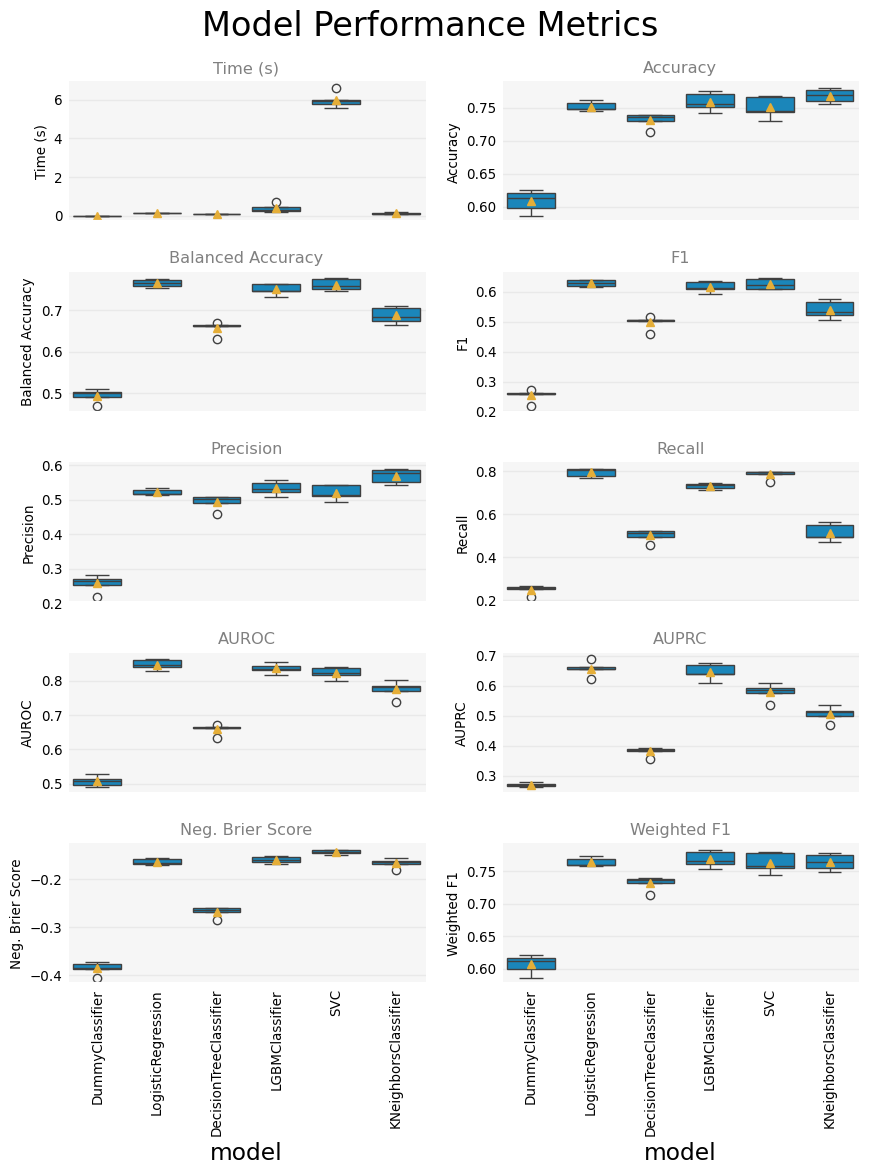

In [16]:
plot_model_performance_metrics(df_results)

We can see that the logistic regression model has the best performance in terms of the
chosen metric and is also one of the fastest models. Besides, it is a very interpretable
model. So, we will choose the logistic regression model as the best model.

Now that we have chosen the best model, we can fine-tune its hyperparameters to improve
its performance.

## Fine-tuning the hyperparameters of the best model

For fine-tuning the hyperparameters, we will use the `GridSearchCV` class from the `sklearn`
library. This class allows us to search for the best hyperparameters of a model by
testing different combinations of hyperparameters.



In [17]:
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [18]:
clf = LogisticRegression(
    random_state=RANDOM_STATE,
    solver="saga",  # supports all penalties
    max_iter=2500,
    class_weight="balanced",
)

grid_search = grid_search_cv_classifier(
    clf, param_grid, kf, preprocessing_not_tree, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot_encoding',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Contract',
                                                                          'Dependents',
                                                                          'DeviceProtection',
                                                                          'InternetService',
                                                                          'OnlineBackup',
                                                                          'OnlineSecurity',
                                                                          'PaperlessBilling',
                                                                          'Partner',
                                                                          'PaymentMethod',
                                                                          'SeniorCitiz...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2500,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision',
                      'neg_brier_score', 'f1_weighted'],
             verbose=1)

In [19]:
grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot_encoding',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Contract',
                                                                          'Dependents',
                                                                          'DeviceProtection',
                                                                          'InternetService',
                                                                          'OnlineBackup',
                                                                          'OnlineSecurity',
                                                                          'PaperlessBilling',
                                                                          'Partner',
                                                                          'PaymentMethod',
                                                                          'SeniorCitiz...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2500,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision',
                      'neg_brier_score', 'f1_weighted'],
             verbose=1)

In [20]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot_encoding',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Contract', 'Dependents',
                                                   'DeviceProtection',
                                                   'InternetService',
                                                   'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'PaperlessBilling',
                                                   'Partner', 'PaymentMethod',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'StreamingTV',
                                                   'TechSupport']),
                                                 ('power_transformer',
                                                  PowerTransformer(),
                                                  ['MonthlyCharges',
                                                   'Tenure'])])),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.25, max_iter=2500,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [21]:
grid_search.best_params_

{'clf__C': 0.1, 'clf__l1_ratio': 0.25, 'clf__penalty': 'elasticnet'}

In [22]:
grid_search.best_score_

np.float64(0.6584247038943914)

It is not a great increase in metrics performance, but it is an improvement. We can see
that the fine-tuned model has an elastic net regularization with a L1 ratio of 0.25 and a
C value of 0.1. This means that the model uses a combination of L1 and L2
regularization, while the vanilla model (`LogisticRegression` with default parameters)
uses only L2 regularization. The low value of C indicates that the model is strongly
regularized, which helps to prevent overfitting.

It is a good practice to check the other metrics to see if the fine-tuned model is not
sacrificing performance in other metrics to improve the chosen metric:


In [23]:
get_mean_and_std_from_grid_search_best_estimator(grid_search)

,score,std
accuracy,0.752234,0.007329
balanced_accuracy,0.766082,0.009746
f1,0.630180,0.011178
precision,0.521791,0.009259
recall,0.795597,0.018686
roc_auc,0.846659,0.012375
average_precision,0.658425,0.020138
neg_brier_score,-0.163604,0.006014
f1_weighted,0.764995,0.006898


We see that our model favors recall in detriment of precision. It seems fine, as we are
more interested in capturing the churn cases.

## Interpreting the model

The coefficients of the logistic regression model can give us some insights into the
importance of each feature in predicting the probability of conversion. We can plot the
coefficients to see which features have the most impact on the probability of
conversion:

In [24]:
coefs = build_coefficients_dataframe(
    grid_search.best_estimator_["clf"].coef_[0],
    grid_search.best_estimator_["preprocessor"].get_feature_names_out(),
)

coefs

,coefficient
power_transformer__Tenure,-0.790589
one_hot_encoding__Contract_Two year,-0.729829
one_hot_encoding__InternetService_DSL,-0.217466
one_hot_encoding__Dependents_Yes,-0.151214
one_hot_encoding__PaymentMethod_Mailed check,-0.087149
one_hot_encoding__OnlineBackup_No internet service,-0.067359
one_hot_encoding__InternetService_No,-0.067359
one_hot_encoding__OnlineSecurity_No internet service,-0.067359
one_hot_encoding__StreamingMovies_No internet service,-0.067359
one_hot_encoding__StreamingTV_No internet service,-0.067359


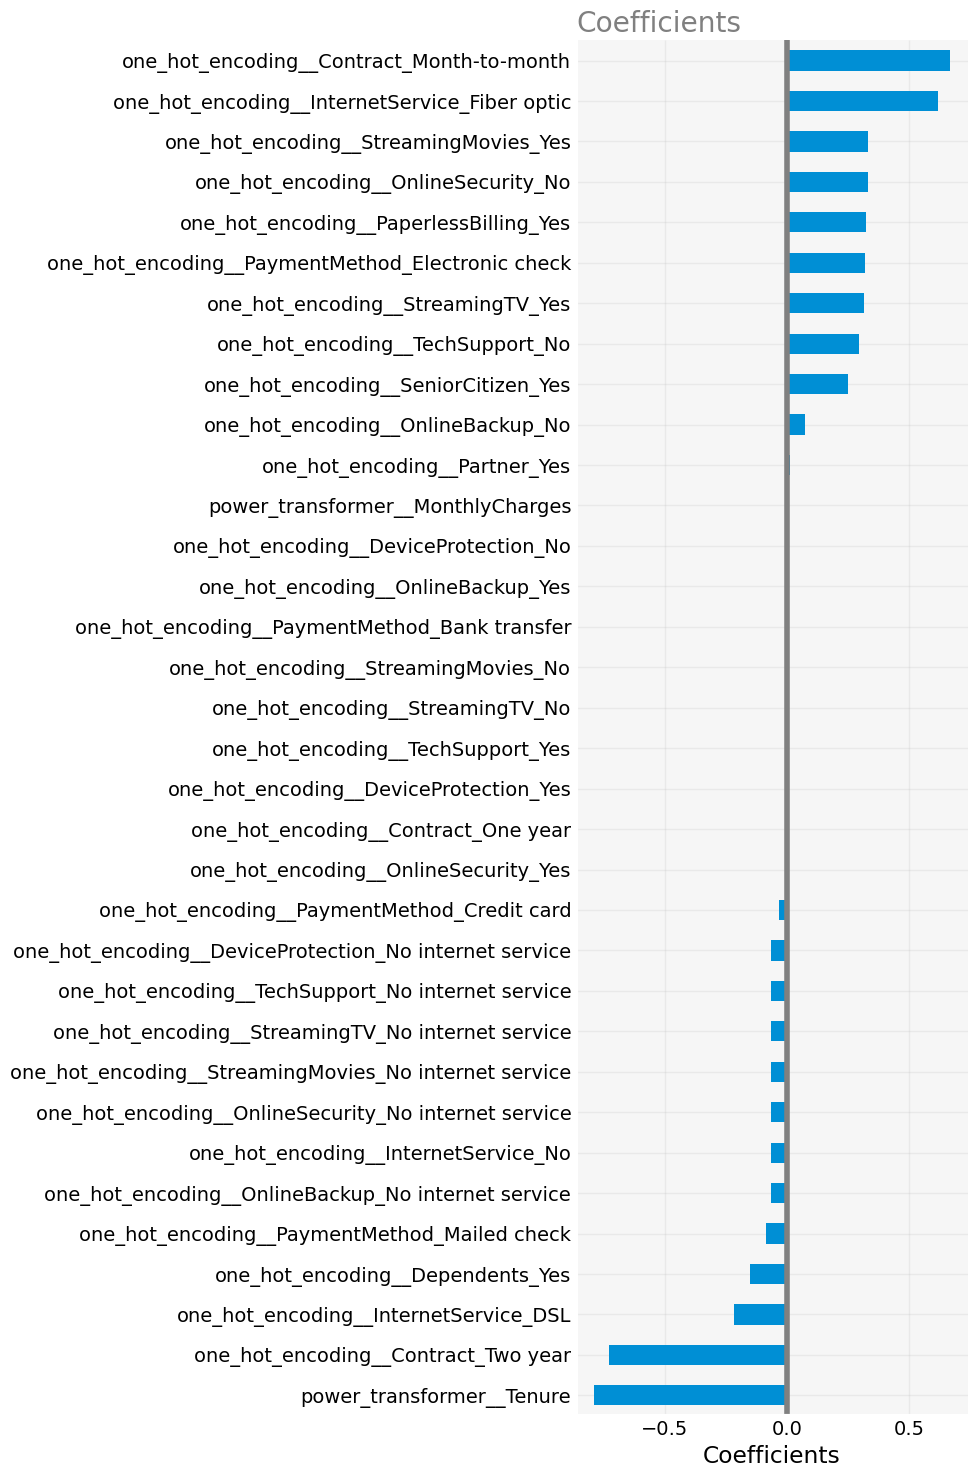

In [25]:
plot_coefficients(coefs)

The coefficients are the weights that the model assigns to each feature. The higher the
absolute value of the coefficient, the more important the feature is in predicting the
probability of churn. The sign of the coefficient indicates the direction of the
relationship between the feature and the target variable. A positive coefficient means
that the feature has a positive impact on the probability of churn, while a
negative coefficient means that the feature has a negative impact on the probability of
churn.

Then, we clearly see that:

- Month-to-month contracts and fiber optic internet service have the highest positive
impact on the probability of churn. It means that customers with month-to-month contracts
and fiber optic internet service are more likely to churn.
- Two-year contracts and longer tenure have the highest negative impact on the
probability of churn. It means that customers with two-year contracts and longer tenure
are less likely to churn.

Both of these results are consistent with the exploratory data analysis we performed in
the previous notebooks. But now we have a quantitative measure of the importance of each
feature in predicting the probability of churn.

Features with zero or near-zero coefficients have little or no impact on the probability
of churn. We are using a regularized logistic regression model, which means that
the model is penalized for having too many features. This is why some features have zero
or near-zero coefficients. The model is trying to reduce the number of features to make
the model simpler and more interpretable.


Mathematically, the coefficients represent the change in the log-odds of the target
variable for a one-unit change in the feature. In other words, the coefficients
represent the impact of the feature on the probability of churn.

Odds are the ratio of the probability of an event happening to the probability of the
event not happening. The log-odds are the natural logarithm of the odds. The logistic
regression model uses the log-odds to make predictions.

I have made an article explaining the interpretation of the coefficients of the logistic
regression model. You can check it out [here](https://franciscobustamante.com.br/portfolio/2025-logistic-regression-coefficients/).
I will briefly explain the interpretation of the coefficients below, but if you want a
more detailed explanation, I recommend reading the article.

For a numerical feature, the coefficient represents the change in the log-odds of the
target variable for a one-unit change in the feature. For example, if the coefficient of
a numerical feature is 0.5, it means that a one-unit increase in the feature is
associated with a 0.5 increase in the log-odds of the target variable.

While for a categorical feature, the coefficient represents the change in the log-odds
of the target variable for a one-unit change from the reference category to the category
represented by the feature. Considering a binary feature, if the coefficient is 0.5, it
means that the category represented by the feature is associated with a 0.5 increase in
the log-odds of the target variable compared to the reference category. For a
multi-class feature, the interpretation is similar.

Interpreting directly the coefficients of the logistic regression model can be
difficult, especially when the features are not scaled, since log-odds is a not
intuitive measure. To make the interpretation easier, we can transform the coefficients
into odds ratios

$$ \text{odds ratio} = e^{w} $$

where $w$ is the coefficient of the feature.

The odds ratio is a more intuitive measure than the log-odds, as it represents the
change in the odds of the target variable for a one-unit change in the feature. An odds
ratio greater than 1 means that the feature has a positive impact on the probability of
churn, while an odds ratio less than 1 means that the feature has a negative impact
on the probability of churn.

We can calculate the odds ratios of the coefficients of the logistic regression model and
plot them to see which features have the most impact on the probability of churn:

In [26]:
coefs_odds = coefs.copy()
coefs_odds["odds_ratio"] = np.exp(coefs_odds["coefficient"])
coefs_odds = coefs_odds.drop(columns="coefficient")

coefs_odds

,odds_ratio
power_transformer__Tenure,0.453578
one_hot_encoding__Contract_Two year,0.481991
one_hot_encoding__InternetService_DSL,0.804555
one_hot_encoding__Dependents_Yes,0.859664
one_hot_encoding__PaymentMethod_Mailed check,0.916540
one_hot_encoding__OnlineBackup_No internet service,0.934859
one_hot_encoding__InternetService_No,0.934859
one_hot_encoding__OnlineSecurity_No internet service,0.934859
one_hot_encoding__StreamingMovies_No internet service,0.934859
one_hot_encoding__StreamingTV_No internet service,0.934859


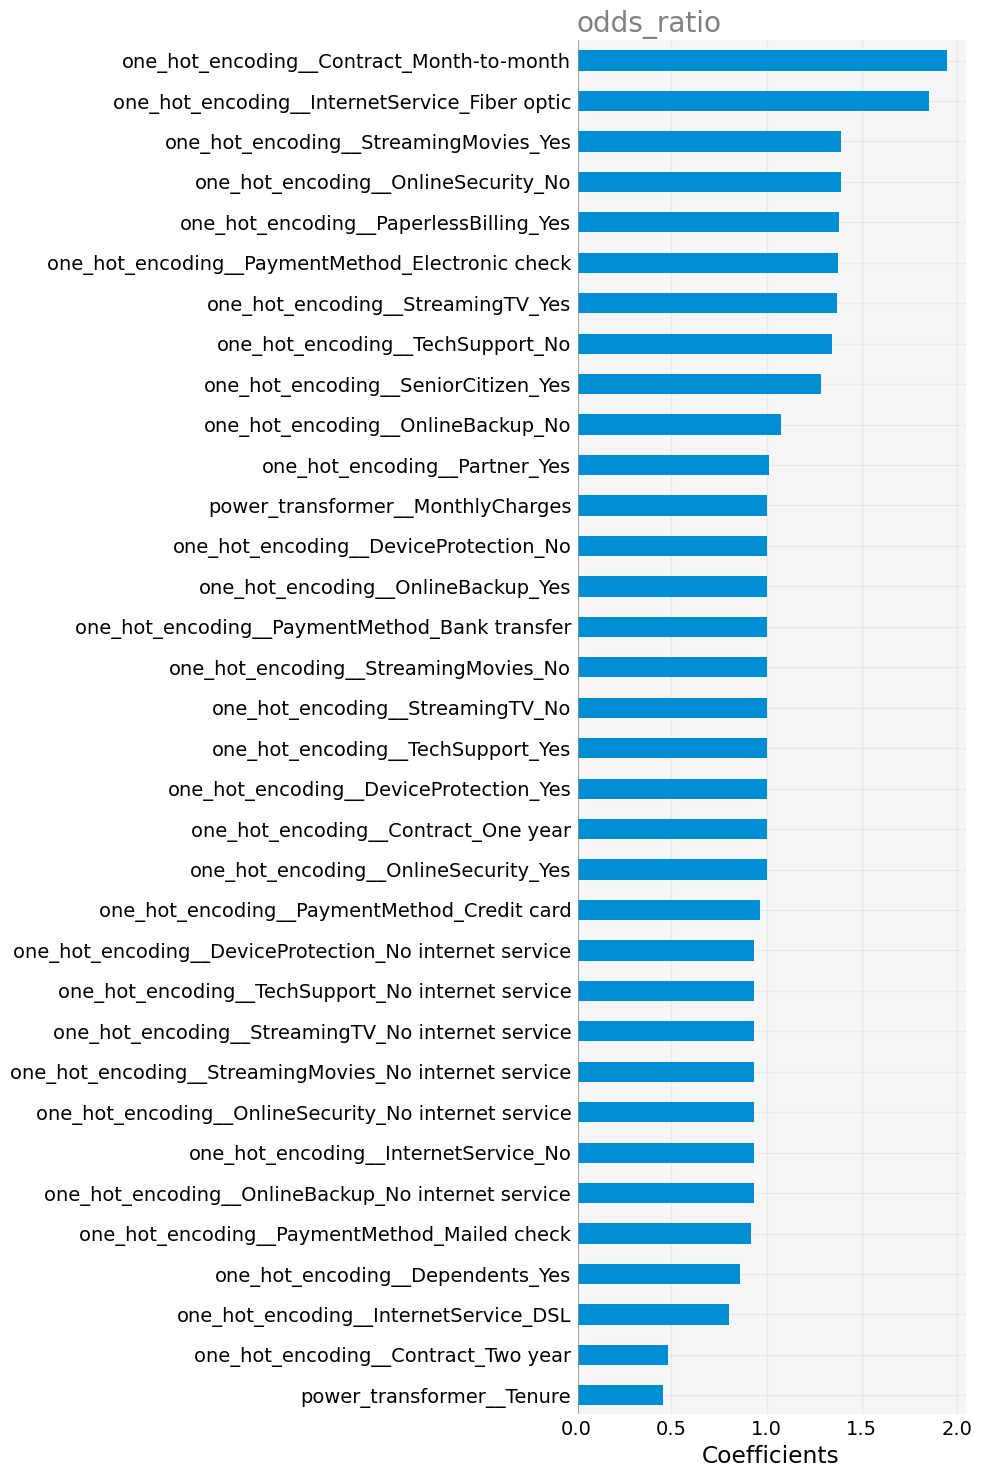

In [27]:
plot_coefficients(coefs_odds, "odds_ratio")

Let's understand our results. We have two numeric features, `Tenure` and `MonthlyCharges`.
The `MonthlyCharges` feature has an odds ratio of 1, which means that a one-unit increase
in the monthly charges is associated with no change in the odds of churn. Our model is
regularized, which means that it tries to reduce the number of features to make the model
simpler and more interpretable. The `MonthlyCharges` feature has, therefore, little or no
impact on the probability of churn according to our model.

The `Tenure` feature has an odds ration of 0.45, which means that a one-unit increase in
the tenure is associated with a 0.45 decrease in the odds of churn.

We also have some categorical features, the main ones being `Contract` and
`InternetService` according to our model.
Both underwent one-hot encoding, so we have multiple coefficients for each feature.

The coefficients of the `Contract` feature represent the change in the log-odds of the target
variable for a one-unit change from the reference category to the category represented by
the feature. 

The odds ratios for each category of the `Contract` feature are as follows:

- Month-to-month: 1.95
- One year: 1
- Two year: 0.48

We can divide the odds ratio of each category by the odds ratio of the reference category
to see how much the odds of churn change for each category compared to the reference
category. The reference category can be any category, but we can choose the category
with the lowest odds ratio as the reference category. In this case, the reference category
is the two-year contract. The values we get are:

- Month-to-month: 4.06
- One year: 2.08
- Two year: 1

This means that customers with month-to-month contracts are 4.06 times more likely to
churn than customers with two-year contracts, while customers with one-year contracts are
2.08 times more likely to churn than customers with two-year contracts. This is consistent
with the exploratory data analysis we performed in the previous notebooks. We saw that
customers with month-to-month contracts are more likely to churn than customers with
one-year or two-year contracts. Now we have a quantitative measure of this relationship.

We can do the same analysis for the `InternetService` feature. The odds ratios for each
category of the `InternetService` feature are as follows:

- Fiber optic: 1.85
- No: 0.93
- DSL: 0.80

Dividing the odds ratio of each category by the odds ratio of the reference category
(the one with the lowest odds ratio), we get:

- Fiber optic: 2.31
- No: 1.16
- DSL: 1

This means that customers with fiber optic internet service are 2.31 times more likely to
churn than customers with DSL internet service, while customers with no internet service
are 1.16 times more likely to churn than customers with DSL internet service. 
It is interesting to note that customers with no internet service are more likely to churn
than customers with DSL internet service.

The model can be exported to be used in a production environment or in future analysis:

In [28]:
joblib.dump(grid_search.best_estimator_, BEST_MODEL_FILE)

['/home/chicolucio/Dropbox/technology/python/projects/ml/churn/models/best_model.joblib']

## Visualizing the model performance

We have seen before the metrics for our fine-tuned model. However, an image is worth a
thousand words. Let's plot the ROC curve, the precision-recall curve and confusion
matrices to visualize the performance of our model. One should have in mind, though,
that these visualizations are not ideal to measure generalization performance. They are
more useful to summarize the results and to communicate the performance of the model to
(technical) stakeholders.

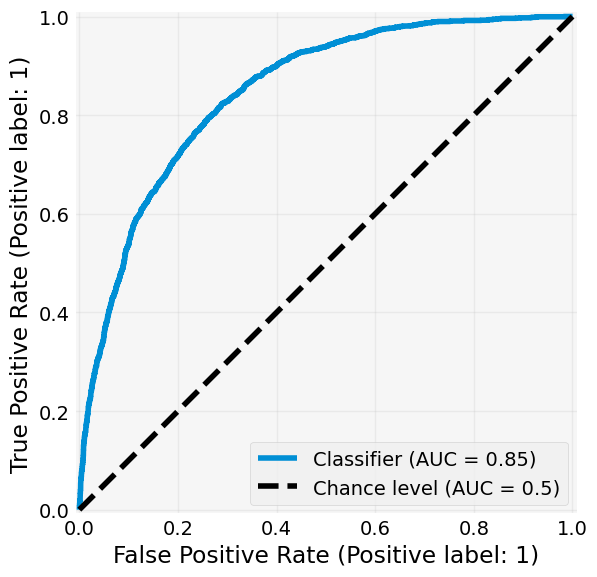

In [29]:
y_pred = cross_val_predict(
    grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="decision_function"
)

fig, ax = plt.subplots(figsize=(8, 6))

roc = RocCurveDisplay.from_predictions(y, y_pred, ax=ax, plot_chance_level=True)

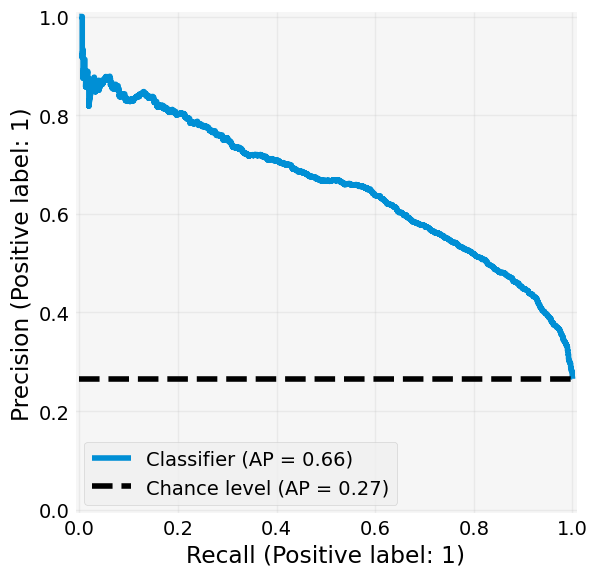

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

prc = PrecisionRecallDisplay.from_predictions(y, y_pred, ax=ax, plot_chance_level=True)

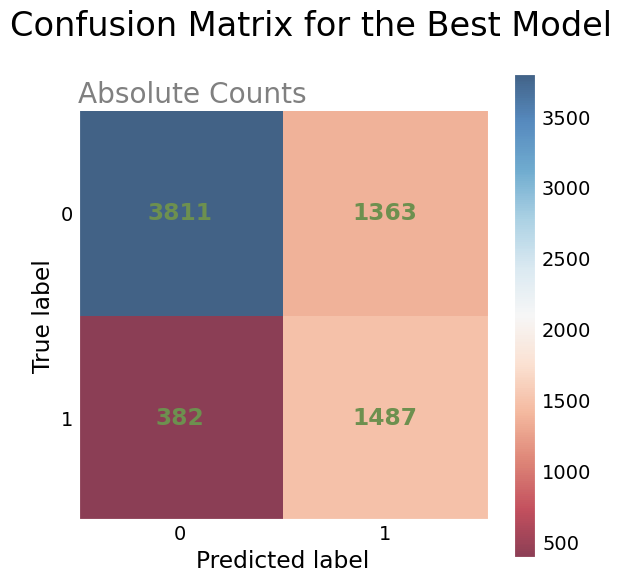

In [31]:
y_pred = cross_val_predict(
    grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="predict"
)

fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    ax=ax,
    cmap="RdBu",
    im_kw={"alpha": 0.75},
    text_kw={"size": "large", "color": "C3", "fontweight": "bold"},
)

fig.suptitle("Confusion Matrix for the Best Model")
ax.set_title("Absolute Counts")

plt.grid(False)
plt.show()

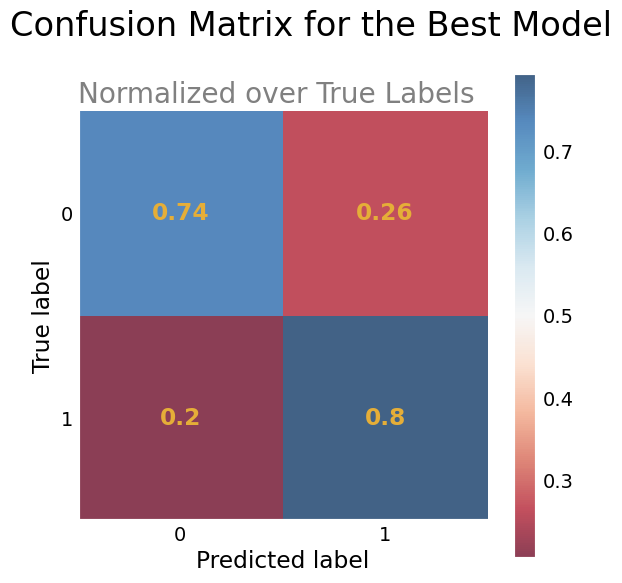

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    normalize="true",
    ax=ax,
    cmap="RdBu",
    im_kw={"alpha": 0.75},
    text_kw={"size": "large", "color": "C2", "fontweight": "bold"},
)

fig.suptitle("Confusion Matrix for the Best Model")
ax.set_title("Normalized over True Labels")

plt.grid(False)
plt.show()

Another plot that could be interesting, although not so common, is the
Kolmogorov-Smirnov plot.

The Kolmogorov-Smirnov (KS) plot is a way to check how well a binary classification
model separates two groups: positives (class = 1) and negatives (class = 0). It helps us
understand if the model is making clear distinctions between the two classes based on
the probabilities it assigns.

The KS plot is based on something called the Cumulative Distribution Function (CDF),
which is just a way of showing how the probabilities are distributed in each class.
Imagine listing all predicted probabilities for a class in order from smallest to
largest. The CDF tells us, for each probability value, how many cases fall at or below
that value.

Consider plot below:

- The blue line represents the positive class (y=1). It shows how many actual positive
cases have a predicted probability less than or equal to a given value.
- The red line represents the negative class (y=0). It shows how many actual negative
cases have a predicted probability less than or equal to that value.
- The KS statistic is the biggest vertical gap between the two lines. This gap tells us
how well the model is distinguishing between positives and negatives.

The KS statistic is a number between 0 and 1 that indicates how well the model separates
the two classes:

- A high KS value (closer to 1) means the model is doing a good job distinguishing
between positives and negatives.
- A low KS value (close to 0) means the model struggles to tell the two classes apart.

If the KS value is greater than 0.4, it usually means the model is making strong
distinctions between the two classes.

This plot is a great way to visually confirm how well a model is performing beyond
standard metrics like accuracy and AUC-ROC.


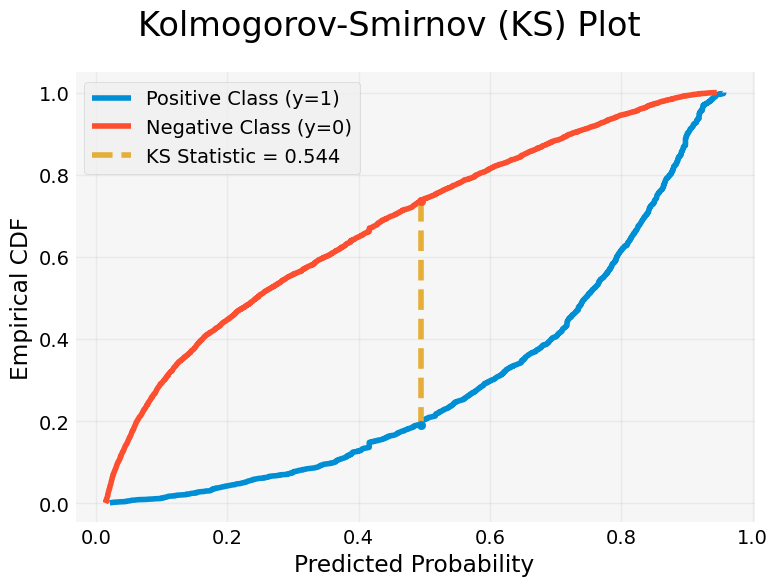

In [33]:
y_pred_proba = grid_search.best_estimator_.predict_proba(X)[:, 1]

plot_ks_curve(y, y_pred_proba)